In [1]:
!pip install -q keras_nlp==0.6.3 keras-core==0.1.7 tensorflow==2.13.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
sqlalchemy 2.0.25 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
albumentations 1.4.0 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
cudf 23.8.0 requir

In [2]:
class color:
    BOLD = '\033[1m'
    BOLD_COLOR = '\033[1m' + '\033[34m'
    END = '\033[0m'

print(color.BOLD_COLOR + 'Importing libarries....\n' + color.END)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
os.environ['KERAS_BACKEND'] = 'jax'

import tensorflow as tf
import keras_nlp
import keras_core as keras
import keras_core.backend as K
import torch

print(color.BOLD + '\nTensorflow Version: {}'.format(tf.__version__))
# print('\nKeras Version: {}'.format(keras.__version__))
print('\nKeras_nlp Version: {}'.format(keras_nlp.__version__))
print('\nKeras Version: {}'.format(keras.__version__))
print('\nTorch Version: {}'.format(torch.__version__)+ color.END)

print(color.BOLD_COLOR + '\nDone!')

Importing libarries....

Using JAX backend.

Tensorflow Version: 2.13.0

Keras_nlp Version: 0.6.3

Keras Version: 0.1.7

Torch Version: 2.1.2

Done!


In [3]:
class CFG:
    verbose = 0

    wandb = True
    competition = 'llm-detect-ai-generated-text'
    _wandb_kernel = 'minh_trinh'
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'

    preset  = 'deberta_v3_base_en'
    sequence_length = 200

    seed = 42

    device = 'TPU'

    num_folds = 5
    selected_folds = [0,1]
    epochs = 3
    batch_size = 3
    drop_remainder = True
    cache = True

    scheduler = 'cosine'

    class_names = ['real','fake']
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels,class_names))
    name2label = {v:k for k,v in label2name.items()}


In [4]:
keras.utils.set_random_seed(CFG.seed)

In [5]:
def get_device():

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(),end = ' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        divice = CFG.device
    except:
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)

        if ngpu:
            strategy = tf.distribute.MirroredStrategy(gpus)
            print('> Running on GPU', end = ' | ')
            print('Num of GPUs: ', ngpu)
            device = 'GPU'
        else:
            print('> Running on GPU')
            strategy = tf.distribute.get_strategy()
            device = 'CPU'

    return strategy,device

In [6]:
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on GPU


In [7]:
BASE_PATH = '/kaggle/input/llm-detect-ai-generated-text'

# Train Data: 1,378
# Sample: 


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,0,real
3,00940276,0,How often do you ride in a car? Do you drive a...,0,0,real
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,0,real


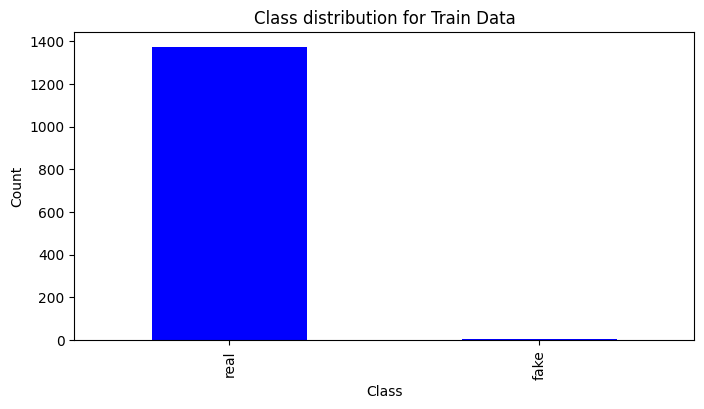

In [8]:
df = pd.read_csv(f'{BASE_PATH}/train_essays.csv')
df['label'] = df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)


print('# Train Data: {:,}'.format(len(df)))
print('# Sample: ')
display(df.head(5))

plt.figure(figsize = (8,4))
df.name.value_counts().plot.bar(color='blue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class distribution for Train Data')
plt.show()

# External Dat: 28,210
# Sample


,essay_id,text,label,source,prompt,fold,name
20120,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
43529,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2942,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
2977,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
31921,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


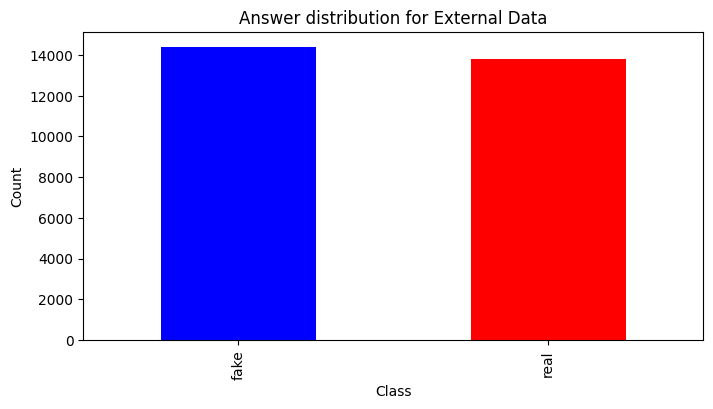

In [9]:
ext_df1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
ext_df2 = pd.read_csv('/kaggle/input/argugpt/argugpt.csv')[['id','text','model']]

ext_df2.rename(columns = {'model': 'source'}, inplace = True)
ext_df2['label'] = 1

ext_df = pd.concat([
    ext_df1[ext_df1.source == 'persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source != 'persuade_corpus']
])

ext_df['name'] = ext_df.label.map(CFG.label2name)

print('# External Dat: {:,}'.format(len(ext_df)))
print('# Sample')
display(ext_df.head(5))

plt.figure(figsize = (8,4))
ext_df.name.value_counts().plot.bar(color=['blue','red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Answer distribution for External Data')
plt.show()

In [10]:
df = ext_df.copy().reset_index(drop=True) # pd.concat([ext_df, df], axis=0)
df.head()

,essay_id,text,label,source,prompt,fold,name
0,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
1,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
3,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
4,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


In [11]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds , shuffle = True, random_state=CFG.seed)

df = df.reset_index(drop = True)
df['stratify'] = df.label.astype(str) + df.source.astype(str)

df['fold'] = -1

for fold,(train_idx,val_idx) in enumerate(skf.split(df,df['stratify'])):
    df.loc[val_idx,'fold'] = fold

df.groupby(['fold','name','source']).size()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


fold  name  source           
0     fake  chat_gpt_moth         484
            darragh_claude_v6     200
            darragh_claude_v7     200
            falcon_180b_v1        211
            llama2_chat           484
                                 ... 
4     fake  radek_500             100
            train_essays            1
      real  original_moth         484
            persuade_corpus      2000
            train_essays          275
Length: 63, dtype: int64

In [12]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset = CFG.preset,
    sequence_length = CFG.sequence_length
)

2464616/2464616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


In [13]:
inp = preprocessor(df.text.iloc[0])

for k,v in inp.items():
    print(k,':',v.shape)

token_ids : (200,)
padding_mask : (200,)


In [14]:
def preprocess_fn(text,label = None):
    text = preprocessor(text)
    return (text,label) if label is not None else text # Return processed text and label if avaibabel

In [15]:
def build_dataset(texts,labels = None,batch_size = 32,cache = False,
                  drop_remainder = True, repeat = False, shuffle = 1024):

    AUTO = tf.data.AUTOTUNE # AUTOTUNE option
    slices = (texts,)if labels is None else(texts,labels) # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices) # Create dataset from slices
    ds = ds.cache() if cache else ds #Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls = AUTO) # Map preprocessing funciton
    ds = ds.repeat() if repeat else ds # Repeat dataset if enabled
    opt = tf.data.Options() # Create dataset option
    if shuffle:
        ds = ds.shuffle(shuffle,seed = CFG.seed) # Shuffle dataset if enbled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt) # Set dataset options
    ds = ds.batch(batch_size,drop_remainder = drop_remainder) # Batch dataset
    ds = ds.prefetch(AUTO)
    return ds # Return the built dataset

In [16]:
def get_datasets(fold):
    train_df = df[df.fold != fold].sample(frac = 1) # Get training fold data
    train_texts = train_df.text.tolist() # Extract training texts
    train_labels = train_df.label.tolist() # Extract training labels

    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,batch_size = CFG.batch_size*CFG.replicas,
                             cache = CFG.cache,shuffle = True, drop_remainder = True, repeat = True)


    valid_df = df[df.fold == fold].sample(frac = 1) # Get validation fold data
    valid_texts = valid_df.text.tolist() # Extract validation texts
    valid_labels = valid_df.label.tolist()# Extract validation label

    #Build validation dataset
    valid_ds = build_dataset(valid_texts,valid_labels,
                             batch_size = min(CFG.batch_size*CFG.replicas,len(valid_df)),
                             cache = CFG.cache, shuffle = False, drop_remainder = True,repeat = False)

    return (train_ds,train_df),(valid_ds,valid_df) # Return datasets and dataframes

In [17]:
!pip install wandb

In [18]:
import wandb # Import wandb library for experiment tracking

try:
    from kaggle_secrets import UserSecretsClient # Import UserSece
    user_secrets = UserSecretsClient() # Create secrets client instance
    api_key = user_secrets.get_secret('WANDB') # Get API key from Kaggle secrets
    wandb.login(key = api_key) # Login to wanbd with the API key
    anonymous = None # Set anonymous mode to None
except:
    anonymous = 'must' # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin = True) # Login to wandb anonymously and relogin if needed

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
# Initiazes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    # Create config dictionary
    config = {k: v for k,v in dict(vars(CFG)).items() if '__' not in k}
    config.update({'fold': int(fold)}) # Add fold to config
    run = wandb.init(project = 'llm-detect-ai-generated-text',
                     name = f'fold-{fold})|max_seq-{CFG.sequence_length}|model-{CFG.preset}',
                     config = config,
                     group = CFG.comment,
                     save_code = True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_auc': best_auc,'best_loss': best_loss,'best_epoch':best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr] #Return WanbB callbacks

In [20]:
import math

def get_lr_callback(batch_size = 8,mode = 'cos', epochs = 10,plot = False):

    lr_start,lr_max,lr_min = 0.6e-6,0.5e-6*batch_size,0.3e-6
    lr_ramp_ep,lr_sus_ep,lr_decay = 1,0,0.75

    def lrfn(epoch): # Learning rate update funtion
        if epoch < lr_ramp_ep:
            lr = (lr_max-lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay ** (epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step':
            lr = lr_max * lr_decay ** ((epoch - lr_ramp_ep - lr_sus_ep)//2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 *(1 + math.cos(phase)) + lr_min
        return lr

    if plot: # Plot lr curve if plot is True
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs),[lrfn(epoch) for epoch in np.arange(epochs)], marker = 'o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn,verbose = False) # Create lr callback

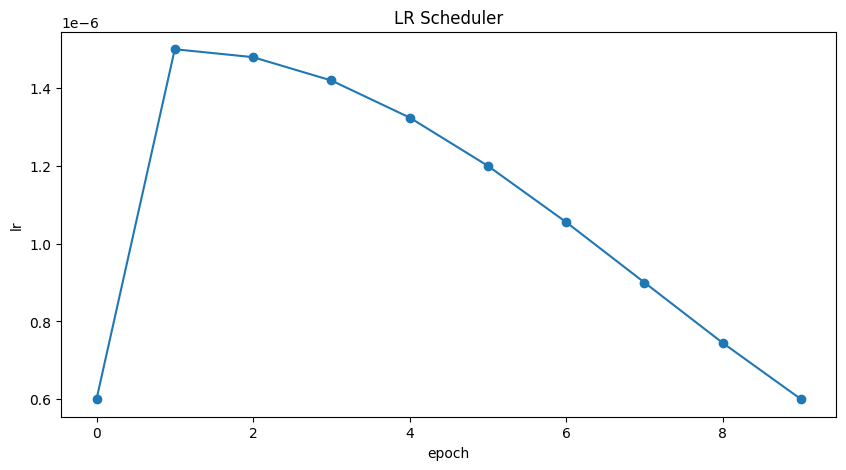

In [21]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot = True)

In [22]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas) # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor = 'val_auc',
                                              save_best_only = True,
                                              save_weights_only = False,
                                              mode = 'max') # Get Model checkpoint callback

    callbacks.extend([lr_cb,ckpt_cb]) #Add learning rate and checkpoint callbacks

    if CFG.wandb: # If wandDB is enabled
        wb_cbs = get_wb_callbacks(fold) #Get WanBD callbacks
        callbacks.extend(wb_cbs)

    return callbacks # Retrun the list of callbacks

In [23]:
def build_model():

    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor = None,
        num_classes = 1 # one output per one option, for five options total 5 outputs
    )

    inputs = classifier.inputs
    logits = classifier(inputs)

    # Compute final output
    #outputs = SigmoidLayer()(logits)
    outputs = keras.layers.Activation('sigmoid')(logits)
    model = keras.Model(inputs, outputs)


    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer = keras.optimizers.AdamW(5e-6),
        loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics = [
            keras.metrics.AUC(name="auc"),
        ],
        jit_compile=True
    )
    return model

In [24]:
# with stratery.scope
model = build_model()

735557816/735557816 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 184,42… │ padding_mask[0][0],  │
│ (DebertaV3Classifi… │                   │         │ token_ids[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 1)         │       0 │ deberta_v3_classifi… │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

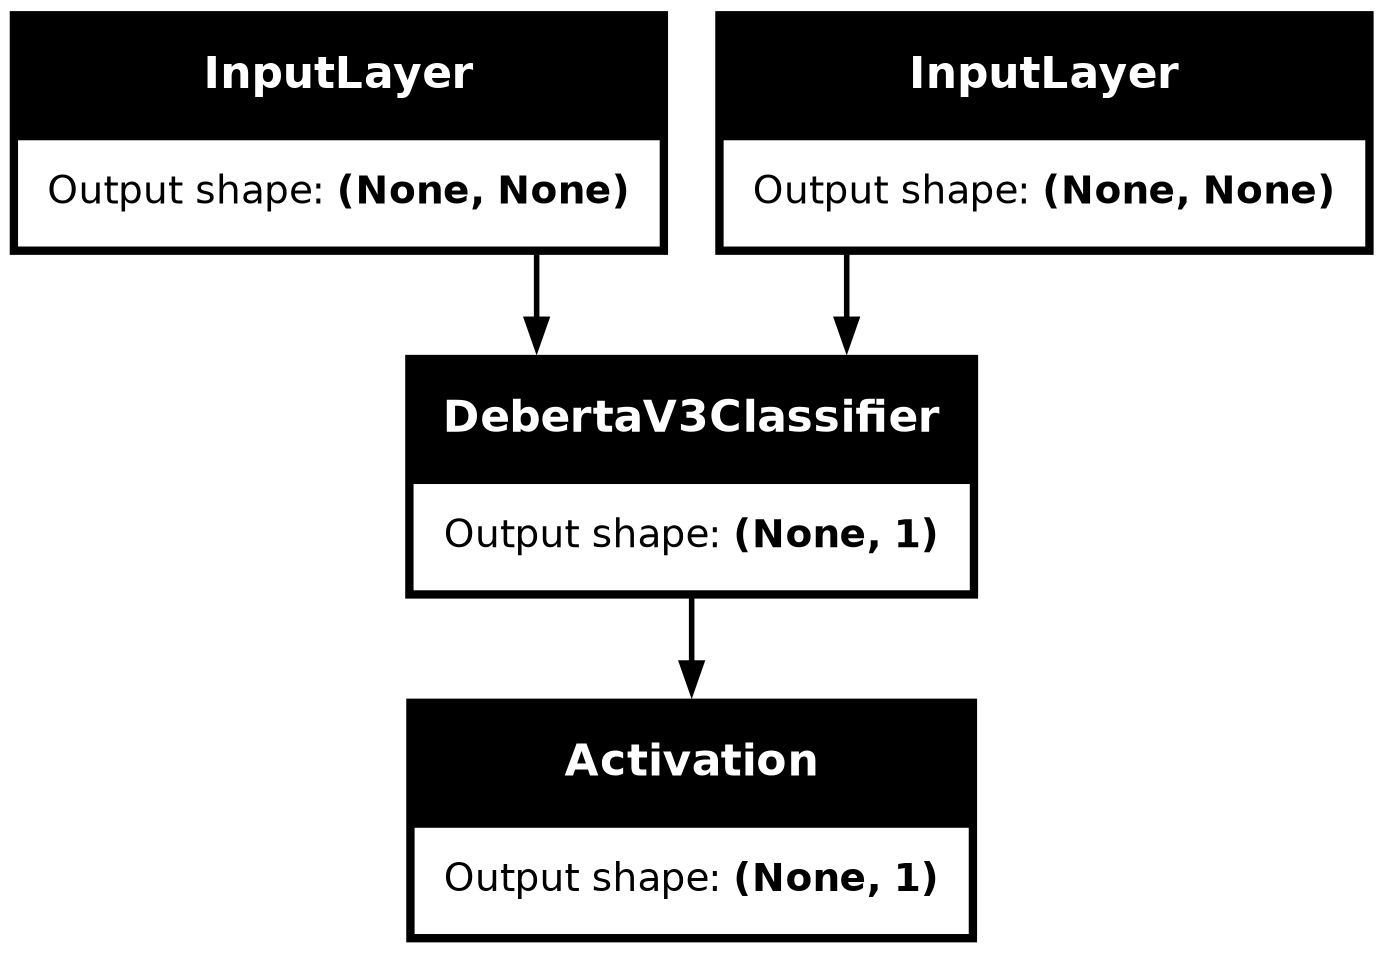

In [26]:
keras.utils.plot_model(model,show_shapes = True)

In [27]:
for fold in CFG.selected_folds:
    # Initialize Weights and Biases if enabled
    if CFG.wandb:
        run = wandb_init(fold)

    # Get train and validation datasets
    (train_ds,train_df),(valid_ds,valid_df) = get_datasets(fold)


    callbacks = get_callbacks(fold)

    # Get Print training information
    print('#' * 50)
    print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch_size: {CFG.batch_size*CFG.replicas} | Scheduler: {CFG.scheduler}')
    print(f'\tNum Train: {len(train_df)} | Num Validation: {len(valid_df)}')
    print('#' * 50)

    # Clear TensorFlow session and build the model within the strategy scope
    K.clear_session()
    with strategy.scope():
        model = build_model()

    # Start training the model
    history = model.fit(
        train_ds,
        epochs = CFG.epochs,
        validation_data = valid_ds,
        callbacks = callbacks,
        steps_per_epoch = int(len(train_df)/ CFG.batch_size/CFG.replicas)
    )

    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(model.history.history['val_auc'])
    best_auc = model.history.history['val_auc'][best_epoch]
    best_loss = model.history.history['val_loss'][best_epoch]

    # Print and display best results
    print(f'\n{"=" * 17} Fold {fold} Results {"=" * 17}')
    print(f'>>>> Best Loss: {best_loss:.3f} \n>>> Best Accuracy: {best_auc:.3f} \n>>> Bets Epochs: {best_epoch}')
    print('=' * 50)

    #Log best result on Weights and Biases (wandb) if enabled
    if CFG.wandb:
        log_wandb() #Log results
        wandb.run.finish() # Finish the run
        # display(ipd.IFrame(run.url,width = 1080,height = 720)) # show wandb dashboard
    print('\n\n')

wandb: Currently logged in as: trinhngocminh1999 (minh_trinh). Use `wandb login --relogin` to force relogin


##################################################
	Fold: 1 | Model: deberta_v3_base_en
	Batch_size: 3 | Scheduler: cosine
	Num Train: 22568 | Num Validation: 5642
##################################################


/opt/conda/lib/python3.10/site-packages/keras_core/src/backend/jax/numpy.py:123: UserWarning: Explicitly requested dtype int64 requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.arange(start, stop, step=step, dtype=dtype)
/opt/conda/lib/python3.10/site-packages/keras_core/src/backend/jax/core.py:58: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=dtype)


Epoch 1/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - auc: 0.9516 - loss: 0.2638

wandb: ERROR Unable to log learning rate.


7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1051s 136ms/step - auc: 0.9516 - loss: 0.2637 - val_auc: 0.9958 - val_loss: 0.1264 - learning_rate: 6.0000e-07
Epoch 2/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1016s 135ms/step - auc: 0.9983 - loss: 0.0771 - val_auc: 0.9963 - val_loss: 0.1290 - learning_rate: 1.5000e-06
Epoch 3/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1018s 135ms/step - auc: 0.9988 - loss: 0.0684 - val_auc: 0.9964 - val_loss: 0.1250 - learning_rate: 1.4796e-06

================= Fold 0 Results =================
>>>> Best Loss: 0.125 
>>> Best Accuracy: 0.996 
>>> Bets Epochs: 2


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁██
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁▇█
epoch/val_loss,▄█▁
best_auc,0.99641
best_epoch,2


##################################################
	Fold: 2 | Model: deberta_v3_base_en
	Batch_size: 3 | Scheduler: cosine
	Num Train: 22568 | Num Validation: 5642
##################################################
Epoch 1/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1070s 139ms/step - auc: 0.9652 - loss: 0.2475 - val_auc: 0.9991 - val_loss: 0.0836 - learning_rate: 6.0000e-07
Epoch 2/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1033s 137ms/step - auc: 0.9984 - loss: 0.0802 - val_auc: 0.9997 - val_loss: 0.0766 - learning_rate: 1.5000e-06
Epoch 3/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1010s 134ms/step - auc: 0.9989 - loss: 0.0704 - val_auc: 0.9996 - val_loss: 0.0700 - learning_rate: 1.4796e-06

================= Fold 1 Results =================
>>>> Best Loss: 0.077 
>>> Best Accuracy: 1.000 
>>> Bets Epochs: 1


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁█▇
epoch/val_loss,█▄▁
best_auc,0.99972
best_epoch,1


In [28]:
predictions = model.predict(
    valid_ds,
    batch_size = min(CFG.batch_size * CFG.replicas * 2, len(valid_df)),
    verbose = 1
)

1880/1880 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step


In [31]:
pred_answers = (predictions > 0.5).astype(int).squeeze()
true_answers = valid_df.label.values

print('Predictions\n')
for i in range(20):
    row = valid_df.iloc[i]
    text = row.text
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f'Text {i+1}:\n{text[:100]}.....{text[-100:]}\n')
    print(f'True: {true_answer}\n')
    print(f'Predictions: {pred_answer}\n')
    print("-"*90,'\n')

Predictions

Text 1:
In recent years, there has been a lot of discussion about the impact of video games on behavior, spe.....ocial behavior. Retrieved from <https://www.sciencedirect.com/science/article/pii/S0193397316300151>

True: fake

Predictions: fake

------------------------------------------------------------------------------------------ 

Text 2:
As an eighth-grade student, I believe that completing high school earlier than the traditional age o.....ers to consider completing high school early and take advantage of all the benefits it has to offer.

True: fake

Predictions: fake

------------------------------------------------------------------------------------------ 

Text 3:
Seeking multiple opinions when making an important decision or looking for advice is almost always t.....iases. The consensus of multiple independent advisors is most likely to result in the wisest choice.

True: fake

Predictions: fake

---------------------------------------------------------------